# Example Notebook for BHPTNRSur2dq1e3

### Goal: Comparison with an NR Surrogate model NRHybSur3dq8

This notebook will provide some comparisons between the BHPTNRSur1dq1e4 and NRHybSur3dq8 models that appear in the [arxiv]().

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gwtools as gwt
from gwtools.gwtools import minimize_norm_error_multi_mode
from gwtools.mismatch import mathcal_E_error_from_mode_dict

import sys
# add the path to the script directory
# provide the path to the BHPTNRSurrogate directory
PATH_TO_BHPTNRSur = "/work/pi_gkhanna_uri_edu/riteshbachhar_uri_edu/Research/Surrogate/BHPTNRSurrogate"

sys.path.append(PATH_TO_BHPTNRSur+"/surrogates")
import BHPTNRSur2dq1e3 as bhptsur

SURROGATE LOADED


In [2]:
# we use NR surrogate models as a proxy for NR
import gwsurrogate as gws

#### Loading NR data ####
# Path to .h5 files 
path_to_nrsur = '/project/u2grc/gwsurrogate_h5/NRHybSur3dq8.h5'
# Surrogate loading
nrsur = gws.LoadSurrogate(path_to_nrsur)

__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
Loaded NRHybSur3dq8 model


In [3]:
def nr_surrogate(q=4, chiA=[0, 0.0, 0.0], chiB=[0.0, 0.0, 0.0], mode_list=None, dt=0.1, f_low=0.005, \
                 f_ref=None, time_shift=False, time_cut_begin=None, time_cut_end=None):
    # q = m1/m2 >= 1
    # dimensionless spin of the heavier BH 
    # dimensionless spin of the lighter BH
    # timestep size, Units of M
    # initial frequency in units of 1/M, f_low=0 returns the full surrogate
    # reference frequecny (1/M). The spins are assumed to specified at this frequency
    # time_shift = True : waveform starts a t=0
    # time_cut_begin applies to starting of the waveform; wrt peak time
    # time_cut_end applies end of the waveform; wrt peak time
    if f_ref==None:
        f_ref=f_low
    
    t, h, dyn = nrsur(q, chiA, chiB, dt=dt, f_low=f_low, f_ref=f_ref)   # dyn stands for dynamics, do dyn.keys() to see contents
    
    if (time_cut_begin != None) and (time_cut_end != None):
        args = np.where((t<=time_cut_end)&(t>=time_cut_begin))[0]
    elif (time_cut_begin != None) and (time_cut_end == None):
        args = np.where(t>=time_cut_begin)[0]
    elif (time_cut_begin == None) and (time_cut_end != None):
        args = np.where(t<=time_cut_end)[0]
    else:
        # All arguments
        args = np.where(t<=t[-1])[0]
    
    if time_shift:
        t = t - t[0]
        
    if mode_list==None:
        mode_list=h.keys()
    
    return t[args], {mode:h[mode][args] for mode in mode_list}

In [4]:
# Proxy for the calibration code
import csv

file_path = '../../data/nrcalib_spinning_fullwf.csv'
alpha_beta_dict = {}

with open(file_path, newline='') as csvfile:
    reader = csv.reader(csvfile)
    
    # Skip the first non-comment row
    for row in reader:
        if not row[0].startswith('#'):
            next(reader)  # Skip this first non-comment row
            break
    
    # Continue processing the rest
    for row in reader:
        if not row[0].startswith('#'):
            alpha_beta_dict[(float(row[1]), float(row[2]))] = list(map(float, row[3:7]))

In [5]:
def scaled_BHPT(q=6, spin1=0.6):
    
    # Evaluate the BHPTNRSur2dq1e3 model
    tbhpt, hbhpt = bhptsur.generate_surrogate(q=q, spin1=spin1, calibrated=False)
    
    if (q, spin1) in alpha_beta_dict:
        beta = alpha_beta_dict[(q,spin1)][0]
        alpha_22 = alpha_beta_dict[(q,spin1)][1]
        alpha_33 = alpha_beta_dict[(q,spin1)][2]
        alpha_44 = alpha_beta_dict[(q,spin1)][3]
    else:
        print("Not calibration data")
        beta = 1
        alpha_22 = 1
        alpha_33 = 1
        alpha_44 = 1
    
    for l, m in hbhpt.keys():
        if l==2:
            hbhpt[(l,m)] = alpha_22*hbhpt[(l,m)]
        if l==3:
            hbhpt[(l,m)] = alpha_33*hbhpt[(l,m)]
        if l==4:
            hbhpt[(l,m)] = alpha_44*hbhpt[(l,m)]
            
    return beta*tbhpt, hbhpt

## Compare BHPTNRSur2dq1e3 and NRHybSur3dq8 at mass ratio q=6, $\chi_1$=0.6

In [6]:
# Mass ratio
q = 6
# Spin 1
spin1 = 0.6
# Evaluate the BHPTNRSur2dq1e3 model without calibration
tbhpt_raw, hbhpt_raw = bhptsur.generate_surrogate(q=q, spin1=spin1, calibrated=False)

# Evaluate the BHPTNRSur2dq1e3 model
tbhpt, hbhpt = scaled_BHPT(q=q, spin1=spin1)

# Evaluate the NRHybSur3dq8 model
tnr, hnr = nr_surrogate(q=q, chiA=[0, 0.0, spin1], chiB=[0.0, 0.0, 0.0], time_cut_begin=-5000.1)

In [7]:
# Requested list of modes for calibration
mode_list = [(2, 2), (2, 1), (3, 3), (4, 4)]

hnr = {mode: hnr[mode] for mode in mode_list}
hbhpt = {mode: hbhpt[mode] for mode in mode_list}

In [8]:
# multi-modal match
[errors_before_min, errors_after_min], [tc, phic], [common_times,h_bhpt_aligned,h_nr_aligned] = \
                            minimize_norm_error_multi_mode(tbhpt, hbhpt, tnr, hnr, mode_list=None, ell_m_match=(2,2),\
                                    t_low_adj=0,t_up_adj=0,method='nelder-mead')

Performing a physical rotation by pi...


In [9]:
# compute error in each mode -- These are the values CalE_{IMR} shown in each figure
modelist = [(2,2),(3,3),(4,4)]
for mode in modelist:
    tmp = gwt.mismatch.mathcal_E_error_from_mode_list(h_nr_aligned[mode],h_bhpt_aligned[mode])
    print("mode (%i, %i) error = %f"%(mode[0],mode[1], tmp))

# compute error in each mode weighted by full multi-modal norm (Eq 21; https://arxiv.org/pdf/1701.00550.pdf)
# This shows that an error of 0.026 in the (4,4) mode (see above) is alternatively understood as an 
# error of 4e-5 then we consider the full waveform in the time-domain. 
relative_mode_errors = gwt.mismatch.mathcal_E_mode_contributions_from_mode_dict(h_nr_aligned,h_bhpt_aligned)
print(relative_mode_errors)

mode (2, 2) error = 0.003049
mode (3, 3) error = 0.016364
mode (4, 4) error = 0.059144
{(2, 2): 0.002931009335330915, (2, 1): 0.0007488479170399742, (3, 3): 0.0005244814178733586, (4, 4): 0.0001708708049942971}


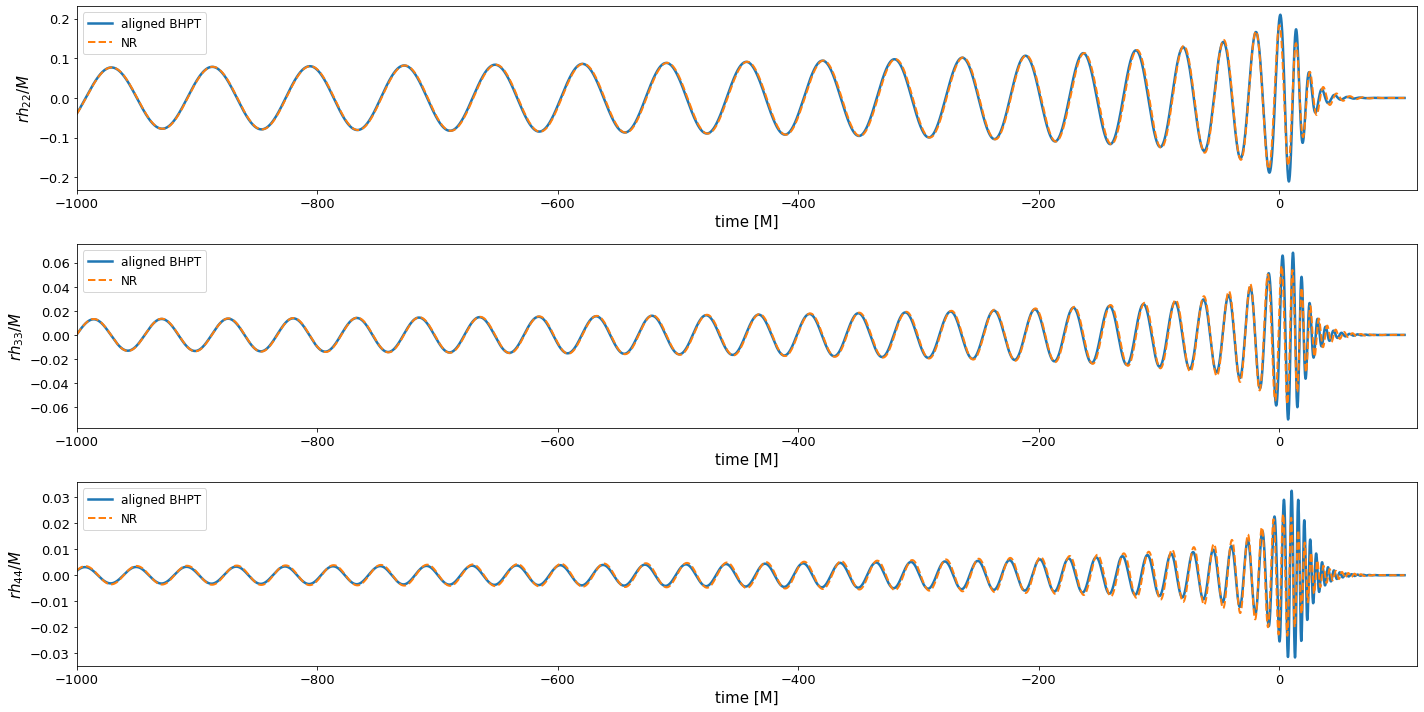

In [10]:
plt.figure(figsize=(20,10))

plt.subplot(311)
plt.plot(common_times, np.real(h_bhpt_aligned[(2,2)]), '-', lw=2.5, label='aligned BHPT')
plt.plot(common_times, np.real(h_nr_aligned[(2,2)]), '--', lw=2.0, label='NR')
plt.xlim(-1000,115)
plt.xlabel('time [M]', fontsize=15)
plt.ylabel(r'$rh_{22}/M$', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)

plt.subplot(312)
plt.plot(common_times, np.real(h_bhpt_aligned[(3,3)]), '-', lw=2.5, label='aligned BHPT')
plt.plot(common_times, np.real(h_nr_aligned[(3,3)]), '--', lw=2.0, label='NR')
plt.xlim(-1000,115)
plt.xlabel('time [M]', fontsize=15)
plt.ylabel(r'$rh_{33}/M$', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)

plt.subplot(313)
plt.plot(common_times, np.real(h_bhpt_aligned[(4,4)]), '-', lw=2.5, label='aligned BHPT')
plt.plot(common_times, np.real(h_nr_aligned[(4,4)]), '--', lw=2.0, label='NR')
plt.xlim(-1000,115)
plt.xlabel('time [M]', fontsize=15)
plt.ylabel(r'$rh_{44}/M$', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Figure 7 from arxiv ####.#####

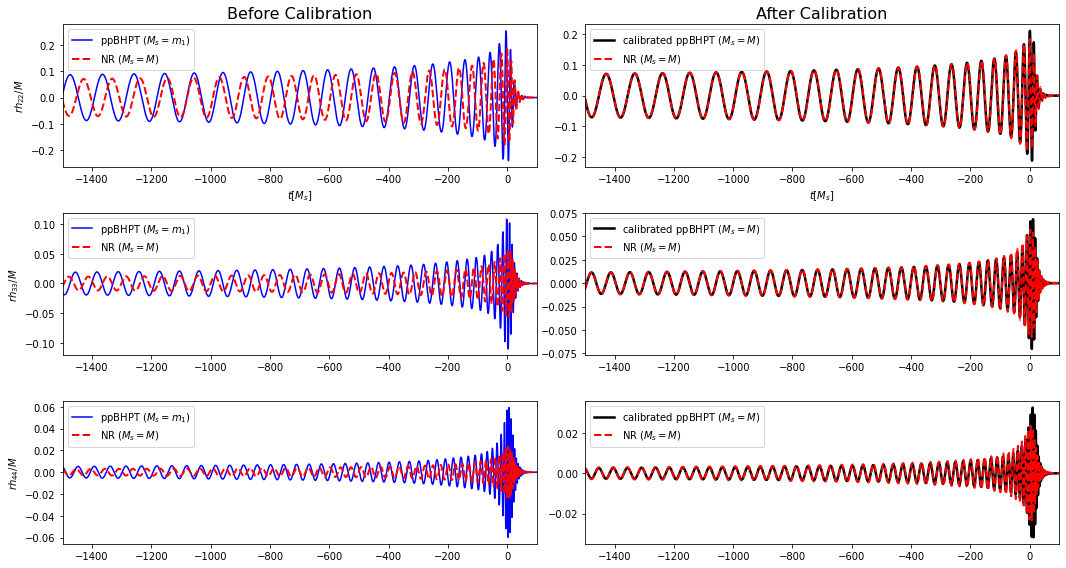

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(15,8))

# Set default text sizes
plt.rcParams['axes.titlesize'] = 16  # Set title size
plt.rcParams['axes.labelsize'] = 14  # Set x and y labels size
plt.rcParams['xtick.labelsize'] = 10  # Set xtick label size
plt.rcParams['ytick.labelsize'] = 10  # Set ytick label size

modelist = [(2,2),(3,3),(4,4)]

for i, mode in enumerate(modelist):
    axs[i,0].plot(tbhpt_raw, np.real(hbhpt_raw[mode]), 'b-', lw=1.5, label=r'ppBHPT ($M_s = m_1$)')
    axs[i,0].plot(tnr, np.real(hnr[mode]), 'r--', lw=2.0, label=r'NR ($M_s = M$)')
    axs[i,0].legend()
    axs[i,0].set_xlim(-1500,100)
    mode_str = ''.join(str(e) for e in mode)
    axs[i,0].set_ylabel(rf'$rh_{{{mode_str}}}/M$',)
    
    axs[i,1].plot(common_times, np.real(h_bhpt_aligned[mode]), 'k-', lw=2.5, label=r'calibrated ppBHPT ($M_s = M$)')
    axs[i,1].plot(common_times, np.real(h_nr_aligned[mode]), 'r--', lw=2.0, label=r'NR ($M_s = M$)')
    axs[i,1].legend()
    axs[i,1].set_xlim(-1500,100)
    mode_str = ''.join(str(e) for e in mode)
    axs[i,0].set_ylabel(rf'$rh_{{{mode_str}}}/M$')

axs[0,0].set_title("Before Calibration")
axs[0,1].set_title("After Calibration")
axs[0,0].set_xlabel("$t [M_s]$")
axs[0,1].set_xlabel("$t [M_s]$")

plt.tight_layout()

## Figure 9.a and 9.c from arXiv xxxx.xxxxx

In [12]:
# Mass ratio
q_list = [3, 5, 8]
spin1_list = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
mode = (2,2)

mathcalE_dict_IMR = {}

for i, q in enumerate(q_list):
    mathcalE_list = []
    for spin1 in spin1_list:
        print(f"Mass ratio {q}, spin1 {spin1}")
        # Evaluate the BHPTNRSur2dq1e3 model
        tbhpt, hbhpt = scaled_BHPT(q=q, spin1=spin1)

        # Evaluate the NRHybSur3dq8 model
        tnr, hnr = nr_surrogate(q=q, chiA=[0, 0.0, spin1], chiB=[0.0, 0.0, 0.0], time_cut_begin=-5000.1)

        # Requested list of modes for calibration
        mode_list = [(2, 2), (2, 1), (3, 3), (4, 4)]

        hnr = {mode: hnr[mode] for mode in mode_list}
        hbhpt = {mode: hbhpt[mode] for mode in mode_list}

        # multi-modal match
        [errors_before_min, errors_after_min], [tc, phic], [common_times,h_bhpt_aligned,h_nr_aligned] = \
                                minimize_norm_error_multi_mode(tbhpt, hbhpt, tnr, hnr, mode_list=None, ell_m_match=(2,2),\
                                        t_low_adj=0,t_up_adj=0,method='nelder-mead')

        mathcalE_list.append(gwt.mismatch.mathcal_E_error_from_mode_list(h_nr_aligned[mode],h_bhpt_aligned[mode]))
    mathcalE_dict_IMR[q] = mathcalE_list

Mass ratio 3, spin1 -0.5
Performing a physical rotation by pi...
Mass ratio 3, spin1 -0.4
Mass ratio 3, spin1 -0.3
Performing a physical rotation by pi...
Mass ratio 3, spin1 -0.2
Performing a physical rotation by pi...
Mass ratio 3, spin1 -0.1
Mass ratio 3, spin1 0.0
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.1
Mass ratio 3, spin1 0.2
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.3
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.4
Mass ratio 3, spin1 0.5
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.6
Mass ratio 3, spin1 0.7
Mass ratio 3, spin1 0.8
Mass ratio 5, spin1 -0.5
Performing a physical rotation by pi...
Mass ratio 5, spin1 -0.4
Mass ratio 5, spin1 -0.3
Performing a physical rotation by pi...
Mass ratio 5, spin1 -0.2
Performing a physical rotation by pi...
Mass ratio 5, spin1 -0.1
Mass ratio 5, spin1 0.0
Performing a physical rotation by pi...
Mass ratio 5, spin1 0.1
Performing a physical rotation by pi...
Mass r

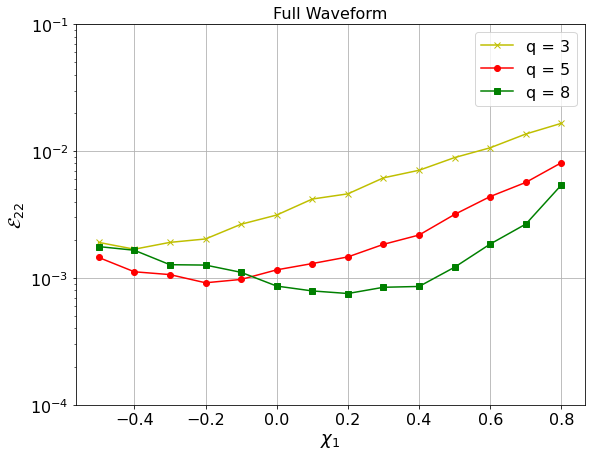

In [13]:
plt.figure(figsize=(8,6))

# Set default text sizes
plt.rcParams['axes.titlesize'] = 16  # Set title size
plt.rcParams['axes.labelsize'] = 18  # Set x and y labels size
plt.rcParams['xtick.labelsize'] = 16  # Set xtick label size
plt.rcParams['ytick.labelsize'] = 16  # Set ytick label size
plt.rcParams['legend.fontsize'] = 16

plt.semilogy(spin1_list, mathcalE_dict_IMR[3], 'y-', marker='x', label='q = 3')
plt.semilogy(spin1_list, mathcalE_dict_IMR[5], 'r-', marker='o', label='q = 5')
plt.semilogy(spin1_list, mathcalE_dict_IMR[8], 'g-', marker='s', label='q = 8')

plt.legend()
plt.ylim(1e-4, 1e-1)
plt.grid()
plt.tight_layout()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\mathcal{E}_{22}$')
plt.title("Full Waveform")
plt.show()

In [15]:
# Mass ratio
q_list = [3, 5, 8]
spin1_list = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
mode = (2,2)

mathcalE_dict_insp = {}

for i, q in enumerate(q_list):
    mathcalE_list = []
    for spin1 in spin1_list:
        print(f"Mass ratio {q}, spin1 {spin1}")
        # Evaluate the BHPTNRSur2dq1e3 model
        tbhpt, hbhpt = scaled_BHPT(q=q, spin1=spin1)

        # Evaluate the NRHybSur3dq8 model
        tnr, hnr = nr_surrogate(q=q, chiA=[0, 0.0, spin1], chiB=[0.0, 0.0, 0.0], time_cut_begin=-5000.1, time_cut_end=-50)

        # Requested list of modes for calibration
        mode_list = [(2, 2), (2, 1), (3, 3), (4, 4)]

        hnr = {mode: hnr[mode] for mode in mode_list}
        hbhpt = {mode: hbhpt[mode] for mode in mode_list}

        # multi-modal match
        [errors_before_min, errors_after_min], [tc, phic], [common_times,h_bhpt_aligned,h_nr_aligned] = \
                                minimize_norm_error_multi_mode(tbhpt, hbhpt, tnr, hnr, mode_list=None, ell_m_match=(2,2),\
                                        t_low_adj=0,t_up_adj=0,method='nelder-mead')

        mathcalE_list.append(gwt.mismatch.mathcal_E_error_from_mode_list(h_nr_aligned[mode],h_bhpt_aligned[mode]))
    mathcalE_dict_insp[q] = mathcalE_list

Mass ratio 3, spin1 -0.5
Mass ratio 3, spin1 -0.4
Performing a physical rotation by pi...
Mass ratio 3, spin1 -0.3
Mass ratio 3, spin1 -0.2
Mass ratio 3, spin1 -0.1
Mass ratio 3, spin1 0.0
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.1
Mass ratio 3, spin1 0.2
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.3
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.4
Mass ratio 3, spin1 0.5
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.6
Mass ratio 3, spin1 0.7
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.8
Mass ratio 5, spin1 -0.5
Mass ratio 5, spin1 -0.4
Performing a physical rotation by pi...
Mass ratio 5, spin1 -0.3
Mass ratio 5, spin1 -0.2
Mass ratio 5, spin1 -0.1
Performing a physical rotation by pi...
Mass ratio 5, spin1 0.0
Mass ratio 5, spin1 0.1
Mass ratio 5, spin1 0.2
Mass ratio 5, spin1 0.3
Performing a physical rotation by pi...
Mass ratio 5, spin1 0.4
Performing a physical rotation by pi...
Mass ratio 5, 

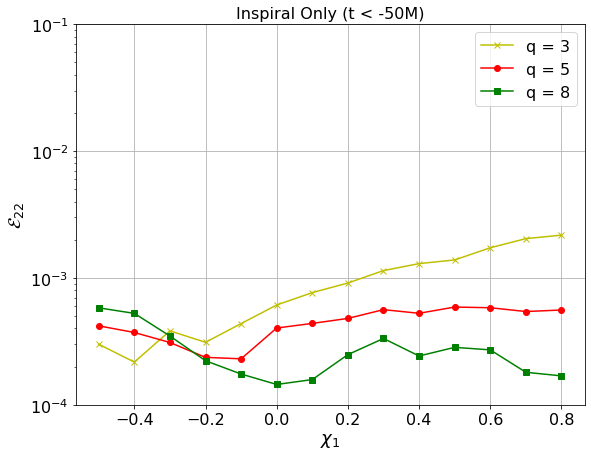

In [17]:
plt.figure(figsize=(8,6))

# Set default text sizes
plt.rcParams['axes.titlesize'] = 16  # Set title size
plt.rcParams['axes.labelsize'] = 18  # Set x and y labels size
plt.rcParams['xtick.labelsize'] = 16  # Set xtick label size
plt.rcParams['ytick.labelsize'] = 16  # Set ytick label size
plt.rcParams['legend.fontsize'] = 16

plt.semilogy(spin1_list, mathcalE_dict_insp[3], 'y-', marker='x', label='q = 3')
plt.semilogy(spin1_list, mathcalE_dict_insp[5], 'r-', marker='o', label='q = 5')
plt.semilogy(spin1_list, mathcalE_dict_insp[8], 'g-', marker='s', label='q = 8')

plt.legend()
plt.ylim(1e-4, 1e-1)
plt.grid()
plt.tight_layout()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\mathcal{E}_{22}$')
plt.title("Inspiral Only (t < -50M)")
plt.show()

### calib data is obtained using fitting functions for \alpha and \beta, scaled data uses best fit values obtained from calibration

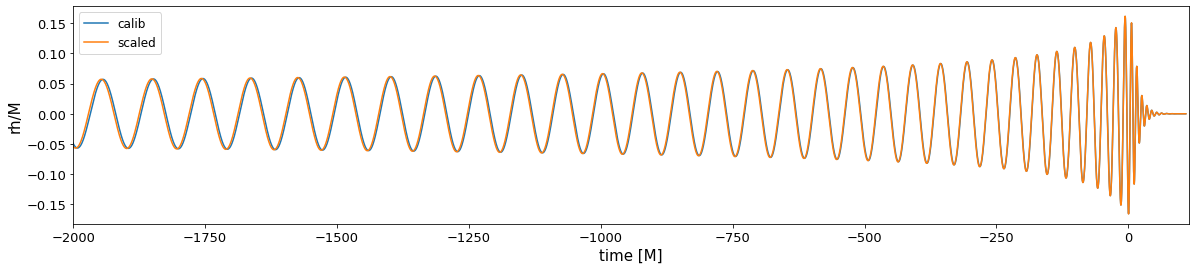

In [11]:
# Mass ratio
q = 8
# Spin 1
spin1 = 0.8
# Evaluate the BHPTNRSur2dq1e3 model without calibration
tbhpt, hbhpt = bhptsur.generate_surrogate(q=q, spin1=spin1, calibrated=True)

# Evaluate the BHPTNRSur2dq1e3 model
tbhpt_scaled, hbhpt_scaled = scaled_BHPT(q=q, spin1=spin1)

# Plot
plt.figure(figsize=(20,4))
plt.plot(tbhpt, gwt.real(hbhpt[(2,2)]), '-', label='calib')
plt.plot(tbhpt_scaled, gwt.real(hbhpt_scaled[(2,2)]), '-', label='scaled')
plt.xlim(-2000,115)
plt.xlabel('time [M]', fontsize=15)
plt.ylabel('rh/M', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)
plt.show()

In [19]:
# Mass ratio
q_list = [3, 5, 8]
spin1_list = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
mode = (2,2)

mathcalE_dict_IMR_2 = {}

for i, q in enumerate(q_list):
    mathcalE_list = []
    for spin1 in spin1_list:
        print(f"Mass ratio {q}, spin1 {spin1}")
        # Evaluate the BHPTNRSur2dq1e3 model
        tbhpt, hbhpt = bhptsur.generate_surrogate(q=q, spin1=spin1, calibrated=True)

        # Evaluate the NRHybSur3dq8 model
        tnr, hnr = nr_surrogate(q=q, chiA=[0, 0.0, spin1], chiB=[0.0, 0.0, 0.0], time_cut_begin=-5000.1)

        # Requested list of modes for calibration
        mode_list = [(2, 2), (2, 1), (3, 3), (4, 4)]

        hnr = {mode: hnr[mode] for mode in mode_list}
        hbhpt = {mode: hbhpt[mode] for mode in mode_list}

        # multi-modal match
        [errors_before_min, errors_after_min], [tc, phic], [common_times,h_bhpt_aligned,h_nr_aligned] = \
                                minimize_norm_error_multi_mode(tbhpt, hbhpt, tnr, hnr, mode_list=None, ell_m_match=(2,2),\
                                        t_low_adj=0,t_up_adj=0,method='nelder-mead')

        mathcalE_list.append(gwt.mismatch.mathcal_E_error_from_mode_list(h_nr_aligned[mode],h_bhpt_aligned[mode]))
    mathcalE_dict_IMR_2[q] = mathcalE_list

Mass ratio 3, spin1 -0.5
Performing a physical rotation by pi...
Mass ratio 3, spin1 -0.4
Mass ratio 3, spin1 -0.3
Performing a physical rotation by pi...
Mass ratio 3, spin1 -0.2
Performing a physical rotation by pi...
Mass ratio 3, spin1 -0.1
Mass ratio 3, spin1 0.0
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.1
Mass ratio 3, spin1 0.2
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.3
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.4
Mass ratio 3, spin1 0.5
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.6
Mass ratio 3, spin1 0.7
Mass ratio 3, spin1 0.8
Mass ratio 5, spin1 -0.5
Performing a physical rotation by pi...
Mass ratio 5, spin1 -0.4
Mass ratio 5, spin1 -0.3
Performing a physical rotation by pi...
Mass ratio 5, spin1 -0.2
Performing a physical rotation by pi...
Mass ratio 5, spin1 -0.1
Mass ratio 5, spin1 0.0
Performing a physical rotation by pi...
Mass ratio 5, spin1 0.1
Performing a physical rotation by pi...
Mass r

In [31]:
# Mass ratio
q_list = [3, 5, 8]
spin1_list = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
mode = (2,2)

mathcalE_dict_insp_2 = {}

for i, q in enumerate(q_list):
    mathcalE_list = []
    for spin1 in spin1_list:
        print(f"Mass ratio {q}, spin1 {spin1}")
        # Evaluate the BHPTNRSur2dq1e3 model
        tbhpt, hbhpt = bhptsur.generate_surrogate(q=q, spin1=spin1, calibrated=True)

        # Evaluate the NRHybSur3dq8 model
        tnr, hnr = nr_surrogate(q=q, chiA=[0, 0.0, spin1], chiB=[0.0, 0.0, 0.0], time_cut_begin=-5000.1, time_cut_end=-50)

        # Requested list of modes for calibration
        mode_list = [(2, 2), (2, 1), (3, 3), (4, 4)]

        hnr = {mode: hnr[mode] for mode in mode_list}
        hbhpt = {mode: hbhpt[mode] for mode in mode_list}

        # multi-modal match
        [errors_before_min, errors_after_min], [tc, phic], [common_times,h_bhpt_aligned,h_nr_aligned] = \
                                minimize_norm_error_multi_mode(tbhpt, hbhpt, tnr, hnr, mode_list=None, ell_m_match=(2,2),\
                                        t_low_adj=0,t_up_adj=0,method='nelder-mead')

        mathcalE_list.append(gwt.mismatch.mathcal_E_error_from_mode_list(h_nr_aligned[mode],h_bhpt_aligned[mode]))
    mathcalE_dict_insp_2[q] = mathcalE_list

Mass ratio 3, spin1 -0.5
Mass ratio 3, spin1 -0.4
Performing a physical rotation by pi...
Mass ratio 3, spin1 -0.3
Mass ratio 3, spin1 -0.2
Mass ratio 3, spin1 -0.1
Mass ratio 3, spin1 0.0
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.1
Mass ratio 3, spin1 0.2
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.3
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.4
Mass ratio 3, spin1 0.5
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.6
Mass ratio 3, spin1 0.7
Performing a physical rotation by pi...
Mass ratio 3, spin1 0.8
Mass ratio 5, spin1 -0.5
Mass ratio 5, spin1 -0.4
Performing a physical rotation by pi...
Mass ratio 5, spin1 -0.3
Mass ratio 5, spin1 -0.2
Mass ratio 5, spin1 -0.1
Performing a physical rotation by pi...
Mass ratio 5, spin1 0.0
Mass ratio 5, spin1 0.1
Mass ratio 5, spin1 0.2
Mass ratio 5, spin1 0.3
Performing a physical rotation by pi...
Mass ratio 5, spin1 0.4
Performing a physical rotation by pi...
Mass ratio 5, 

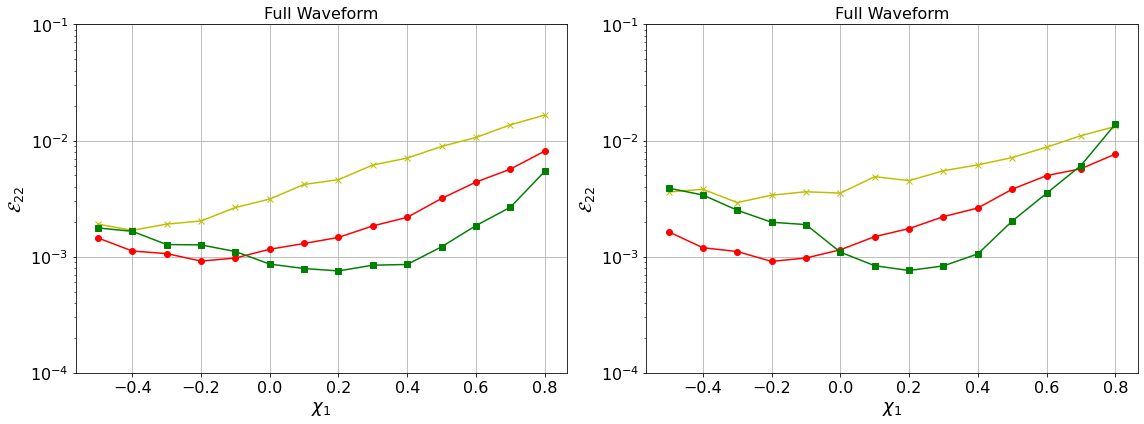

In [28]:
# Set default text sizes
plt.rcParams['axes.titlesize'] = 16  # Set title size
plt.rcParams['axes.labelsize'] = 18  # Set x and y labels size
plt.rcParams['xtick.labelsize'] = 16  # Set xtick label size
plt.rcParams['ytick.labelsize'] = 16  # Set ytick label size
plt.rcParams['legend.fontsize'] = 16

fig,axs=plt.subplots(1, 2, figsize=(16,6))

axs[0].semilogy(spin1_list, mathcalE_dict_IMR[3], 'y-', marker='x', label='q = 3')
axs[0].semilogy(spin1_list, mathcalE_dict_IMR[5], 'r-', marker='o', label='q = 5')
axs[0].semilogy(spin1_list, mathcalE_dict_IMR[8], 'g-', marker='s', label='q = 8')
axs[0].set_xlabel(r'$\chi_1$')
axs[0].set_ylabel(r'$\mathcal{E}_{22}$')
axs[0].set_title("Full Waveform")
axs[0].grid()
axs[0].set_ylim(1e-4, 1e-1)

axs[1].semilogy(spin1_list, mathcalE_dict_IMR_2[3], 'y-', marker='x', label='q = 3')
axs[1].semilogy(spin1_list, mathcalE_dict_IMR_2[5], 'r-', marker='o', label='q = 5')
axs[1].semilogy(spin1_list, mathcalE_dict_IMR_2[8], 'g-', marker='s', label='q = 8')
axs[1].set_xlabel(r'$\chi_1$')
axs[1].set_ylabel(r'$\mathcal{E}_{22}$')
axs[1].set_title("Full Waveform")
axs[1].grid()
axs[1].set_ylim(1e-4, 1e-1)

# plt.legend()
# plt.ylim(1e-4, 1e-1)
# plt.grid()
plt.tight_layout()
plt.show()

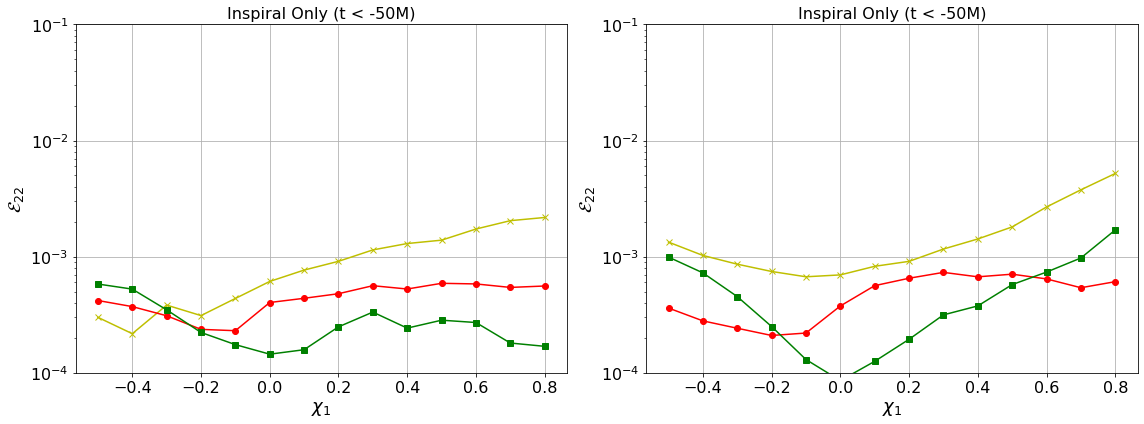

In [32]:
# Set default text sizes
plt.rcParams['axes.titlesize'] = 16  # Set title size
plt.rcParams['axes.labelsize'] = 18  # Set x and y labels size
plt.rcParams['xtick.labelsize'] = 16  # Set xtick label size
plt.rcParams['ytick.labelsize'] = 16  # Set ytick label size
plt.rcParams['legend.fontsize'] = 16

fig,axs=plt.subplots(1, 2, figsize=(16,6))

axs[0].semilogy(spin1_list, mathcalE_dict_insp[3], 'y-', marker='x', label='q = 3')
axs[0].semilogy(spin1_list, mathcalE_dict_insp[5], 'r-', marker='o', label='q = 5')
axs[0].semilogy(spin1_list, mathcalE_dict_insp[8], 'g-', marker='s', label='q = 8')
axs[0].set_xlabel(r'$\chi_1$')
axs[0].set_ylabel(r'$\mathcal{E}_{22}$')
axs[0].set_title("Inspiral Only (t < -50M)")
axs[0].grid()
axs[0].set_ylim(1e-4, 1e-1)

axs[1].semilogy(spin1_list, mathcalE_dict_insp_2[3], 'y-', marker='x', label='q = 3')
axs[1].semilogy(spin1_list, mathcalE_dict_insp_2[5], 'r-', marker='o', label='q = 5')
axs[1].semilogy(spin1_list, mathcalE_dict_insp_2[8], 'g-', marker='s', label='q = 8')
axs[1].set_xlabel(r'$\chi_1$')
axs[1].set_ylabel(r'$\mathcal{E}_{22}$')
axs[1].set_title("Inspiral Only (t < -50M)")
axs[1].grid()
axs[1].set_ylim(1e-4, 1e-1)

# plt.legend()
# plt.ylim(1e-4, 1e-1)
# plt.grid()
plt.tight_layout()
plt.show()